In [1]:
!sshfs -o reconnect,ServerAliveInterval=120,ServerAliveCountMax=3 rennes.g5k:/srv/storage/empenn@storage2.rennes.grid5000.fr/private/ymerel /home/ymerel/storage

In [61]:
import os

datadir = os.path.join('data')
result_dir = os.path.join('results')
corr_path = os.path.join(datadir, 'correlations.csv')
corr_func = 'spearman'
ds_path = os.path.join(datadir, 'normalized_dataset.csv')
valid_path = os.path.join(datadir, f'valid_dataset.csv')
invalid_path = os.path.join(datadir, f'invalid_dataset.csv')
basedir = "/home/ymerel/storage/results/"
jobname = "auditory"
result_path = f"{basedir}{jobname}"

# Load data

In [62]:
import pandas as pd

dataset = dataset = pd.read_csv(ds_path, delimiter=';')
valid_df = pd.read_csv(valid_path, delimiter=';')
valid_df = valid_df.drop('cluster', axis=1)
invalid_df = pd.read_csv(invalid_path, delimiter=';')

print(f"{len(dataset)} configs in dataset")

correlations = pd.read_csv(corr_path, delimiter=';')
correlations = correlations.rename(columns={"correlation": "spearman"})
print(f"{len(correlations)} correlations in matrix")

matrix = correlations.pivot(index='source', columns='target', values=corr_func).fillna(1.0)

dataset.head(1010)

1001 configs in dataset
1004003 correlations in matrix


,slice_timing_correction/ref_slice/middle,signal_modeling/hrf/temporal_dispersion_derivs,coregistration/cost_function/mutual_information,signal_modeling/nuisance_regressors/comp_cor,signal_modelling/temporal_noise_autocorrelation/FAST,spatial_normalization/algorithm/DARTEL,spatial_normalization/interpolation/bspline,spatial_normalization/bias_regularisation,spatial_normalization/template/MNI152_linear,spatial_normalization/bias_regularisation/extremely_light,...,spatial_normalization/template/MNI305,spatial_normalization/bias_fwhm,spatial_normalization/bias_regularisation/very_light,coregistration/source_target/anat_on_func,slice_timing_correction/ref_slice/first,spatial_normalization/interpolation/nearest_neighbour,signal_modeling/hrf/canonical,id,spearman_from_ref,spearman_from_mean
0,False,True,True,False,False,False,False,False,False,0,...,False,0,0,True,False,True,False,0a3e49ee189809ec52afbdb3c3c5083f090dcb0d218326...,0.467386,0.533488
1,True,False,False,False,True,False,True,False,False,0,...,False,0,0,False,False,False,False,5c20760d37a8aa728efbbec6efc518da72c638cc88cdcd...,0.624349,0.671276
2,True,True,False,False,False,False,True,False,False,0,...,False,0,0,True,False,False,False,3097a7dc41788499cf25575641e12f92017eaec464039b...,0.054786,0.265940
3,False,True,False,False,False,False,False,False,False,0,...,False,0,0,True,True,True,False,bbb3beabd28e8a1d0f553be543e76a38246c1416fbfb00...,0.455374,0.584125
4,True,True,False,False,True,False,False,False,False,0,...,False,0,0,False,False,False,False,63bea197905677a189c165af71c8fc3933529cfb732832...,0.054786,0.265940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,False,False,False,False,False,False,False,False,False,0,...,False,0,0,False,True,False,False,91801a03dc14fd0a3028e8181828cd0d92bd12b830c86f...,0.123223,0.368549
997,False,False,False,False,True,False,False,False,False,0,...,False,0,0,True,False,True,False,ffcb718b2eaf9394c568665e65cb40e5b070ae63c2dd91...,0.070953,0.282691
998,False,False,False,False,False,False,True,False,False,0,...,False,0,0,True,False,False,False,c870f6446e080d90673cfac597ca16e081ea1b510ce78c...,0.138238,0.392617
999,True,True,False,False,True,False,True,False,False,0,...,False,0,0,True,False,False,False,315c85bdd9845ee4f5d15e689759ac1971849341a8b9b8...,0.588806,0.661417


# Declare cluster prediction method

In [63]:
from scipy.optimize import linear_sum_assignment
from utils import get_cluster_silhouette
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz, DecisionTreeClassifier
import numpy as np

metrics = ["spearman"]

def assign_clusters(dataset, dataset_with_clusters, ids, correlations):
    xdf = (correlations[correlations.source.isin(ids)]
        .merge(dataset_with_clusters.loc[dataset_with_clusters.id != "ref", ["id", "cluster"]], how="right", left_on="target", right_on="id"))
    clusters = (xdf.groupby(["source", "cluster"])[metrics]
        .mean()  # mean per source and cluster
        .mean(axis=1)  # mean of metrics
        .reset_index(name="mean_correlation")
        .loc[lambda d: d.groupby("source")["mean_correlation"].idxmax()])
    
    dataset_clustered = dataset.merge(clusters[["source", "cluster"]], left_on="id", right_on="source").drop(columns=["source"])
    return dataset_clustered

def relabel_clusters(ds_to_relabel, ds_reference, correlations):
    assert ds_to_relabel["cluster"].nunique() == ds_reference["cluster"].nunique(), "Number of clusters doesn't match"
    
    num_clusters = ds_to_relabel["cluster"].nunique()
    cluster_correlation = np.zeros((num_clusters, num_clusters))
    
    for source_cluster in range(1, num_clusters+1):
        for target_cluster in range(1, num_clusters+1):
            avg_corr = correlations[correlations.source.isin(ds_to_relabel[ds_to_relabel["cluster"] == source_cluster]["id"]) & correlations.target.isin(ds_reference[ds_reference["cluster"] == target_cluster]["id"])][metrics].mean().mean()
            cluster_correlation[source_cluster-1][target_cluster-1] = avg_corr
    
    old_cluster_idx, new_cluster_idx = linear_sum_assignment(cluster_correlation, maximize=True)
    cluster_mapping = dict(zip(old_cluster_idx+1, new_cluster_idx+1))
    ds_to_relabel["cluster"] = ds_to_relabel["cluster"].replace(to_replace=cluster_mapping)
    return ds_to_relabel

@ignore_warnings(category=UserWarning)
def predict_clusters(dataset, correlations, nb_clusters, threshold, test_prop=0.1):
    
    ignored = [col for col in dataset.columns if col.endswith('from_ref')]
    ignored.extend([col for col in dataset.columns if col.endswith('from_mean')])
    ignored.extend(['id', 'cluster'])
    
    train_ds, test_ds = train_test_split(dataset, test_size=test_prop, random_state=None)
    
    train_ds_clustered, matrix, _, _ = clusterize_hierch(train_ds, correlations, train_ds['id'], nb_clusters, corr_func, threshold)

    threshold_based = threshold is not None

    if not threshold_based:
        test_ds_clustered = assign_clusters(test_ds, train_ds_clustered, test_ds["id"], correlations)
        test_ds_clustered = test_ds_clustered.sample(frac=1, random_state=None).reset_index(drop=True)
        y_test = test_ds_clustered['cluster']
        X_test = test_ds_clustered.drop(columns=ignored).copy()

    results_list = []
    
    proportions = np.round(np.arange(0.2, 1.1, 0.1), decimals=1)
    for prop in proportions:
        
        train_size = int(prop * (len(train_ds)))
    
        results = {
            'train_size': train_size,
            'f1_score': 0.0,
            'feature_importance': {},
            'decision_tree': None,  # Only store the last tree
            'nb_features': 0.0,
            'nb_clusters': 0.0,
            'silhouette_score': -1
        }
    
        # Split into train and test sets
        if prop == 1.0:
            sub_train_ds = train_ds.copy()
        else:
            sub_train_ds, _ = train_test_split(train_ds, train_size=train_size, random_state=None)

        sub_train_ds_clustered, matrix, _, _ = clusterize_hierch(sub_train_ds, correlations, sub_train_ds['id'], nb_clusters, corr_func, threshold)

        if threshold_based:
            test_ds_clustered = assign_clusters(test_ds, sub_train_ds_clustered, test_ds["id"], correlations)
            y_test = test_ds_clustered['cluster']
            X_test = test_ds_clustered.drop(columns=ignored).copy()
        else:
            # This relabels the clusters found by giving each cluster the same as the closest one in the full training set
            # To have a 1:1 mapping (i.e. without changing the number of clusters), we must solve a linear assignment problem
            # This make this relabeling produce some overhead...
            sub_train_ds_clustered = relabel_clusters(sub_train_ds_clustered, train_ds_clustered, correlations)
            
        # Re-create `clusters` return value from clusterize_hierch, because we might have changed the cluster labels
        clusters = sub_train_ds_clustered.reset_index()[["id", "cluster"]].set_index("id")["cluster"].sort_index()
        
        sub_train_ds_clustered = sub_train_ds_clustered.sample(frac=1, random_state=None).reset_index(drop=True)
        y_train = sub_train_ds_clustered['cluster']
        results['nb_clusters'] = y_train.nunique()
        X_train = sub_train_ds_clustered.drop(columns=ignored).copy()
        
        results['silhouette_score'] = get_cluster_silhouette(matrix.values, clusters.values)
    
        # Train the classifier
        classifier = DecisionTreeClassifier(random_state=None)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
    
        # Classification report
        all_classes = sorted(set(y_test.unique()).union(set(np.unique(y_pred))))
        target_names = [str(name) for name in all_classes]
        report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True, zero_division=0)
        results['f1_score'] = report['macro avg']['f1-score']
        results['recall'] = report['macro avg']['recall']
        results['precision'] = report['macro avg']['precision']
    
        # Feature importances
        features = X_train.columns
        importances = classifier.feature_importances_
        results['feature_importance'] = {feat: imp for feat, imp in zip(features, importances) if imp > 0.0}
        results['nb_features'] = len(results['feature_importance'])
    
        results['decision_tree'] = export_graphviz(
            classifier,
            out_file=None,
            feature_names=X_train.columns.values,
            filled=True,
            rounded=True,
            special_characters=True,
            leaves_parallel=True,
            proportion=True
        )
    
        results_list.append(results)

    return pd.DataFrame(results_list)

## [Full] Cluster  by [2 .. 20] clusters over 10 iterations

In [64]:
import graphviz
from utils import clusterize_hierch
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from tqdm import tqdm

nb_iter = 10
max_nb_clusters = 20

def run_single_prediction(args):
  """Run a single prediction for a given iteration and number of clusters."""
  ds, corrs, iteration, nbc = args
  results_df = predict_clusters(ds, corrs, nbc, None, 0.3)
  results_df['iteration'] = iteration
  return results_df

In [6]:

# Generate all (iteration, nb_clusters) combinations
tasks = [(dataset, correlations, i, nbc)
       for i in range(1, nb_iter+1)
       for nbc in range(2, max_nb_clusters+1)]

print(f"Running {len(tasks)} tasks in parallel...")

with ProcessPoolExecutor(mp_context=multiprocessing.get_context('fork')) as executor:
  all_results = list(tqdm(executor.map(run_single_prediction, tasks), total=len(tasks)))

classifier_full_results = pd.concat(all_results, ignore_index=True)
classifier_full_results.to_csv(os.path.join(result_dir, f'classifier_full_clusters.csv'), index=False, sep=';')

Running 190 tasks in parallel...


100%|██████████| 190/190 [32:28<00:00, 10.26s/it] 


In [77]:
classifier_full_results = pd.read_csv(os.path.join(result_dir, f'classifier_full_clusters.csv'), delimiter=';')

nb_clusters = 4

# print graph
max_train_size = classifier_full_results.loc[classifier_full_results['iteration'] == nb_iter, 'train_size'].max()
decision_tree = classifier_full_results.loc[
  (classifier_full_results['train_size'] == max_train_size) &
  (classifier_full_results['iteration'] == nb_iter) &
  (classifier_full_results['nb_clusters'] == nb_clusters),
  'decision_tree'
].iloc[0]
graph = graphviz.Source(decision_tree)
graph.render(os.path.join(result_dir, f"full_{nb_clusters}_clusters"), format='svg')
classifier_full_results.head(500)

,train_size,f1_score,feature_importance,decision_tree,nb_features,nb_clusters,silhouette_score,recall,precision,iteration
0,140,1.000000,{'coregistration/cost_function/normalised_cros...,"digraph Tree {\nnode [shape=box, style=""filled...",1,2,0.448989,1.000000,1.000000,1
1,210,1.000000,{'coregistration/cost_function/normalised_cros...,"digraph Tree {\nnode [shape=box, style=""filled...",1,2,0.438685,1.000000,1.000000,1
2,280,1.000000,{'coregistration/cost_function/normalised_cros...,"digraph Tree {\nnode [shape=box, style=""filled...",1,2,0.443986,1.000000,1.000000,1
3,350,1.000000,{'coregistration/cost_function/normalised_cros...,"digraph Tree {\nnode [shape=box, style=""filled...",1,2,0.448967,1.000000,1.000000,1
4,420,1.000000,{'coregistration/cost_function/normalised_cros...,"digraph Tree {\nnode [shape=box, style=""filled...",1,2,0.456459,1.000000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...
495,140,0.860902,{'slice_timing_correction/ref_slice/middle': n...,"digraph Tree {\nnode [shape=box, style=""filled...",8,19,0.533573,0.881579,0.877193,3
496,210,0.820709,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",4,19,0.528383,0.833214,0.855013,3
497,280,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",4,19,0.533818,1.000000,1.000000,3
498,350,0.839599,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",4,19,0.533700,0.855263,0.854386,3


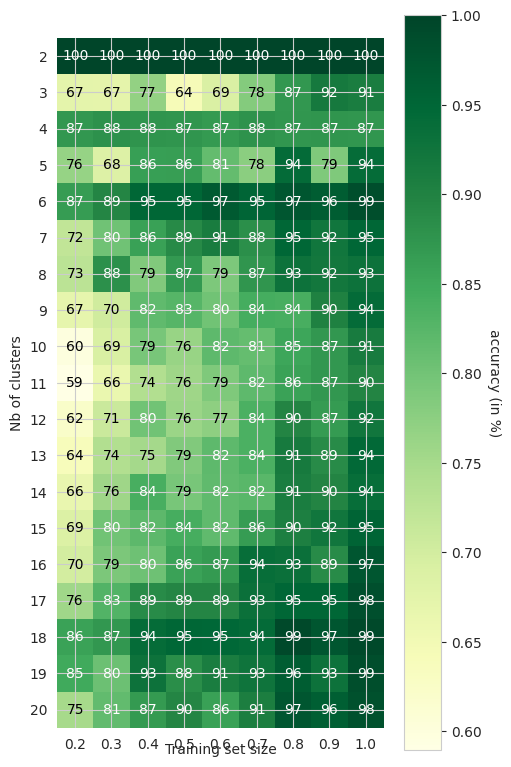

<Axes: xlabel='train_size', ylabel='F1-Score'>

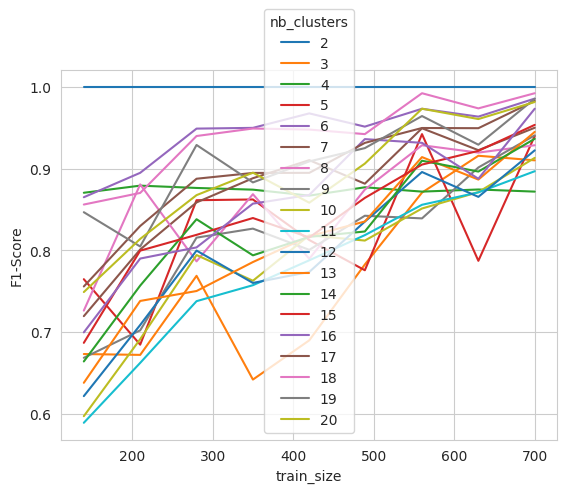

In [66]:
import matplotlib.pyplot as plt
heatmap = classifier_full_results[["train_size", "nb_clusters", "f1_score"]].groupby(["train_size", "nb_clusters"]).mean().reset_index().pivot(columns="train_size", index="nb_clusters")
fig, ax = plt.subplots(figsize=(5,8))
im = ax.imshow(heatmap, cmap="YlGn")


cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("accuracy (in %)", rotation=-90, va="bottom")
ax.set_xlabel("Training set size", va="bottom")
ax.set_ylabel("Nb of clusters", va="bottom")
ax.set_yticks(range(len(heatmap.index)), heatmap.index)
ax.set_xticks(range(len(heatmap.columns)), (heatmap.columns.get_level_values(1)/700).round(2))

# Loop over data dimensions and create text annotations.

threshold = im.norm(heatmap.values.max())/2.

textcolors=("black", "white")

for i in range(len(heatmap.index)):
    for j in range(len(heatmap.columns)):
        text = ax.text(j, i, (heatmap.values[i, j].round(2)*100).astype(int),
                       ha="center", va="center", color=textcolors[int(im.norm(heatmap.values[i, j]) > threshold)])
ax.spines[:].set_visible(False)

# ax.set_xticks(np.arange(heatmap.values.shape[1]+1)-.5, minor=True)
# ax.set_yticks(np.arange(heatmap.values.shape[0]+1)-.5, minor=True)
# ax.grid(which="minor", color="w", linestyle='', linewidth=0)
# ax.tick_params(which="minor", bottom=False, left=False)

fig.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = classifier_full_results[["train_size", "nb_clusters", "f1_score"]].groupby(["train_size", "nb_clusters"]).mean().reset_index().pivot(index="train_size", columns="nb_clusters")
data.columns = data.columns.droplevel(0)
data.reset_index().plot("train_size", ylabel="F1-Score")


# Plot prediction results (full dataset)

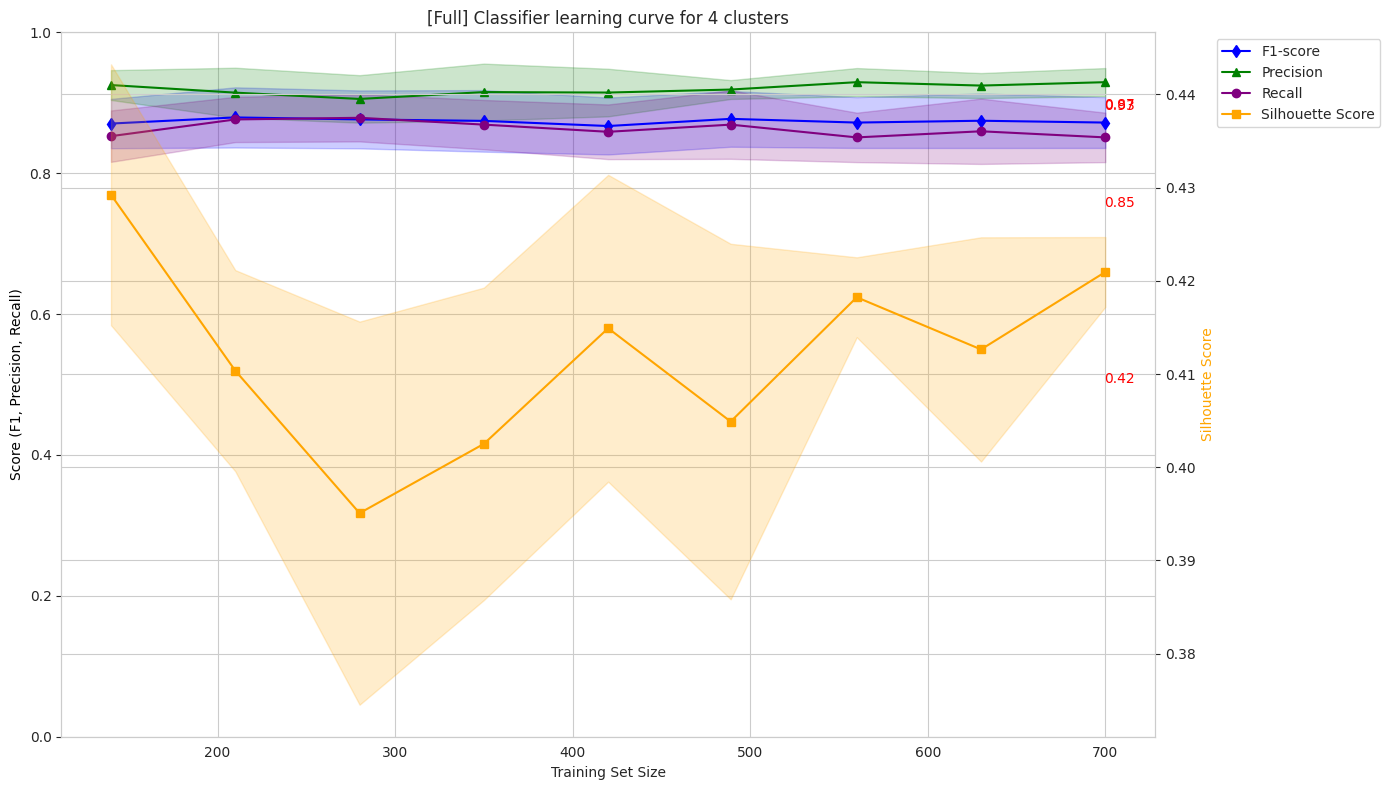

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

classifier_full_results_cluster = classifier_full_results[classifier_full_results['nb_clusters'] == nb_clusters]

# Group by train_size and calculate mean and std for all metrics
grouped_f1 = classifier_full_results_cluster.groupby('train_size')['f1_score'].agg(['mean', 'std']).reset_index()
grouped_precision = classifier_full_results_cluster.groupby('train_size')['precision'].agg(['mean', 'std']).reset_index()
grouped_recall = classifier_full_results_cluster.groupby('train_size')['recall'].agg(['mean', 'std']).reset_index()
grouped_features = classifier_full_results_cluster.groupby('train_size')['silhouette_score'].agg(['mean', 'std']).reset_index()

# Use the unique train_size values from the grouped data for the x-axis
train_sizes = grouped_f1['train_size'].unique()

# Plotting
plt.figure(figsize=(14, 8))

# Primary axis for F1-score, Precision, and Recall
ax1 = plt.gca()
ax1.set_xlabel('Training Set Size')
ax1.set_ylabel('Score (F1, Precision, Recall)', color='black')
ax1.set_ylim(0, 1)

# Plot F1-score
ax1.plot(
    train_sizes,
    grouped_f1['mean'],
    marker='d',
    label='F1-score',
    color='blue'
)
ax1.fill_between(
    train_sizes,
    grouped_f1['mean'] - grouped_f1['std'],
    grouped_f1['mean'] + grouped_f1['std'],
    alpha=0.2,
    color='blue'
)

# Plot Precision
ax1.plot(
    train_sizes,
    grouped_precision['mean'],
    marker='^',
    label='Precision',
    color='green'
)
ax1.fill_between(
    train_sizes,
    grouped_precision['mean'] - grouped_precision['std'],
    grouped_precision['mean'] + grouped_precision['std'],
    alpha=0.2,
    color='green'
)

# Plot Recall
ax1.plot(
    train_sizes,
    grouped_recall['mean'],
    marker='o',
    label='Recall',
    color='purple'
)
ax1.fill_between(
    train_sizes,
    grouped_recall['mean'] - grouped_recall['std'],
    grouped_recall['mean'] + grouped_recall['std'],
    alpha=0.2,
    color='purple'
)

# Annotate the last values
ax1.annotate(
    f'{grouped_f1["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_f1["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

ax1.annotate(
    f'{grouped_precision["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_precision["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -20),
    ha='center',
    fontsize=10,
    color='red'
)

ax1.annotate(
    f'{grouped_recall["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_recall["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -50),
    ha='center',
    fontsize=10,
    color='red'
)

# Secondary axis for Silhouette Score
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='orange')
ax2.plot(
    train_sizes,
    grouped_features['mean'],
    marker='s',
    label='Silhouette Score',
    color='orange'
)
ax2.fill_between(
    train_sizes,
    grouped_features['mean'] - grouped_features['std'],
    grouped_features['mean'] + grouped_features['std'],
    alpha=0.2,
    color='orange'
)

# Annotate the last value of Silhouette Score
ax2.annotate(
    f'{grouped_features["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_features["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -80),
    ha='center',
    fontsize=10,
    color='red'
)

# Place the legend outside the figure
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title(f'[Full] Classifier learning curve for {nb_clusters} clusters')
plt.grid(True)
plt.tight_layout()
plt.show()


## [Valid] Cluster  by [2 .. 20] clusters over 10 iterations

In [68]:
import graphviz
from utils import clusterize_hierch
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from tqdm import tqdm

nb_iter = 10
max_nb_clusters = 20

def run_single_prediction(args):
  """Run a single prediction for a given iteration and number of clusters."""
  ds, corrs, iteration, nbc = args
  results_df = predict_clusters(ds, corrs, nbc, None, 0.3)
  results_df['iteration'] = iteration
  return results_df

In [28]:

# Generate all (iteration, nb_clusters) combinations
tasks = [(valid_df, correlations, i, nbc)
       for i in range(1, nb_iter+1)
       for nbc in range(2, max_nb_clusters+1)]

print(f"Running {len(tasks)} tasks in parallel...")

with ProcessPoolExecutor(mp_context=multiprocessing.get_context('fork')) as executor:
  all_results = list(tqdm(executor.map(run_single_prediction, tasks), total=len(tasks)))

classifier_valid_results = pd.concat(all_results, ignore_index=True)
classifier_valid_results.to_csv(os.path.join(result_dir, f'classifier_valid_clusters.csv'), index=False, sep=';')

Running 190 tasks in parallel...


100%|██████████| 190/190 [33:21<00:00, 10.53s/it] 


In [78]:
classifier_valid_results = pd.read_csv(os.path.join(result_dir, f'classifier_valid_clusters.csv'), delimiter=';')

# print graph
max_train_size = classifier_valid_results.loc[classifier_valid_results['iteration'] == nb_iter, 'train_size'].max()
decision_tree = classifier_valid_results.loc[
  (classifier_valid_results['train_size'] == max_train_size) &
  (classifier_valid_results['nb_clusters'] == nb_clusters) &
  (classifier_valid_results['iteration'] == nb_iter),
  'decision_tree'
].iloc[0]
graph = graphviz.Source(decision_tree)
graph.render(os.path.join(result_dir, f"valid_{nb_clusters}_clusters"), format='svg')
classifier_valid_results.head(500)

,train_size,f1_score,feature_importance,decision_tree,nb_features,nb_clusters,silhouette_score,recall,precision,iteration
0,105,0.914098,{'spatial_smoothing/fwhm': np.float64(0.983653...,"digraph Tree {\nnode [shape=box, style=""filled...",2,2,0.403855,0.931655,0.910377,1
1,157,0.863901,{'spatial_smoothing/fwhm': np.float64(1.0)},"digraph Tree {\nnode [shape=box, style=""filled...",1,2,0.421465,0.844828,0.918675,1
2,210,0.865987,{'spatial_smoothing/fwhm': np.float64(1.0)},"digraph Tree {\nnode [shape=box, style=""filled...",1,2,0.361204,0.892086,0.871795,1
3,263,0.865987,{'spatial_smoothing/fwhm': np.float64(1.0)},"digraph Tree {\nnode [shape=box, style=""filled...",1,2,0.378230,0.892086,0.871795,1
4,315,0.863901,{'spatial_smoothing/fwhm': np.float64(1.0)},"digraph Tree {\nnode [shape=box, style=""filled...",1,2,0.437958,0.844828,0.918675,1
...,...,...,...,...,...,...,...,...,...,...
495,105,0.723317,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",5,19,0.599636,0.744361,0.738489,3
496,157,0.958333,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",4,19,0.544813,0.952632,0.975146,3
497,210,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",3,19,0.559454,1.000000,1.000000,3
498,263,0.977671,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",3,19,0.573606,0.973684,0.991228,3


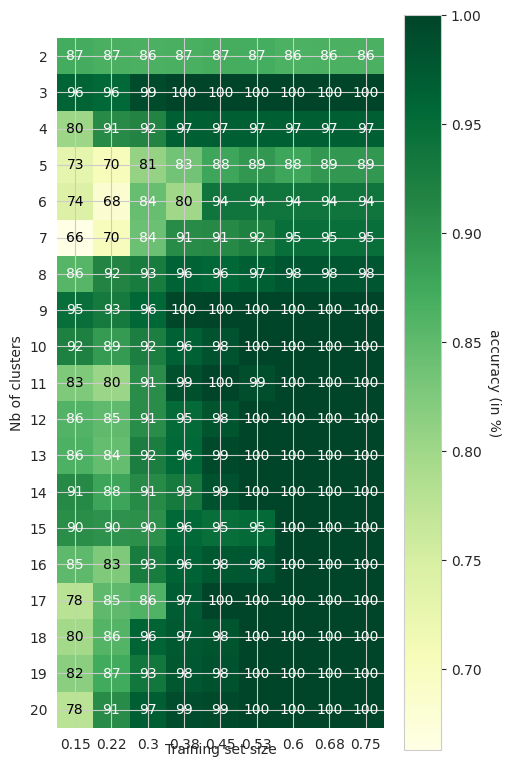

<Axes: xlabel='train_size', ylabel='F1-Score'>

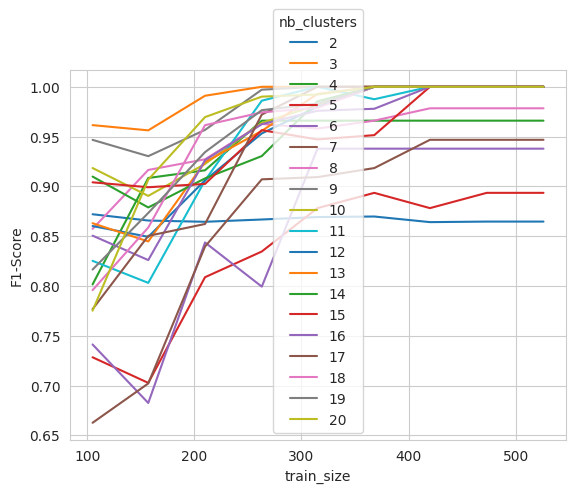

In [70]:
import matplotlib.pyplot as plt
heatmap = classifier_valid_results[["train_size", "nb_clusters", "f1_score"]].groupby(["train_size", "nb_clusters"]).mean().reset_index().pivot(columns="train_size", index="nb_clusters")
fig, ax = plt.subplots(figsize=(5,8))
im = ax.imshow(heatmap, cmap="YlGn")


cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("accuracy (in %)", rotation=-90, va="bottom")
ax.set_xlabel("Training set size", va="bottom")
ax.set_ylabel("Nb of clusters", va="bottom")
ax.set_yticks(range(len(heatmap.index)), heatmap.index)
ax.set_xticks(range(len(heatmap.columns)), (heatmap.columns.get_level_values(1)/700).round(2))

# Loop over data dimensions and create text annotations.

threshold = im.norm(heatmap.values.max())/2.

textcolors=("black", "white")

for i in range(len(heatmap.index)):
    for j in range(len(heatmap.columns)):
        text = ax.text(j, i, (heatmap.values[i, j].round(2)*100).astype(int),
                       ha="center", va="center", color=textcolors[int(im.norm(heatmap.values[i, j]) > threshold)])
ax.spines[:].set_visible(False)

# ax.set_xticks(np.arange(heatmap.values.shape[1]+1)-.5, minor=True)
# ax.set_yticks(np.arange(heatmap.values.shape[0]+1)-.5, minor=True)
# ax.grid(which="minor", color="w", linestyle='', linewidth=0)
# ax.tick_params(which="minor", bottom=False, left=False)

fig.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = classifier_valid_results[["train_size", "nb_clusters", "f1_score"]].groupby(["train_size", "nb_clusters"]).mean().reset_index().pivot(index="train_size", columns="nb_clusters")
data.columns = data.columns.droplevel(0)
data.reset_index().plot("train_size", ylabel="F1-Score")


# Plot prediction results (valid dataset)

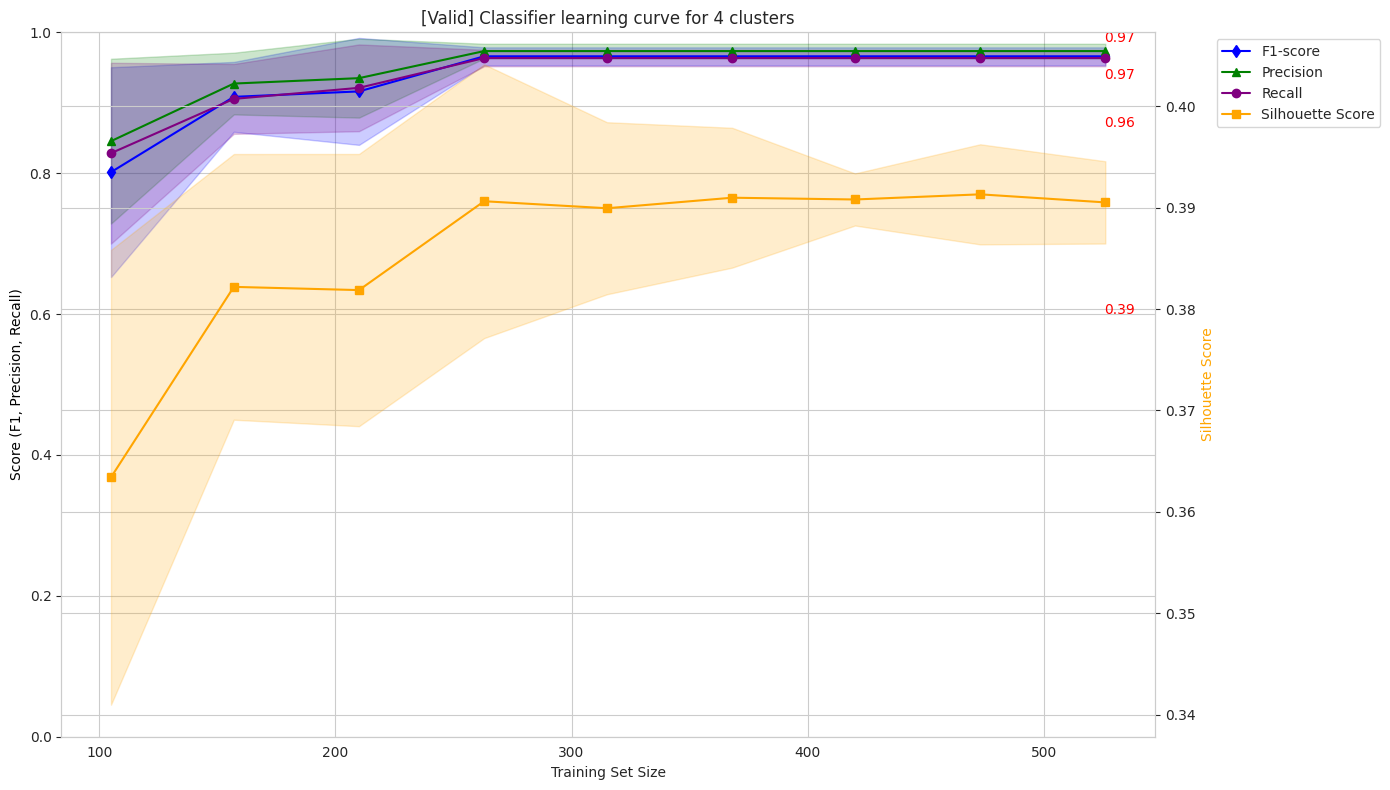

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

results_per_cluster = classifier_valid_results[classifier_full_results['nb_clusters'] == 4]

# Group by train_size and calculate mean and std for all metrics
grouped_f1 = results_per_cluster.groupby('train_size')['f1_score'].agg(['mean', 'std']).reset_index()
grouped_precision = results_per_cluster.groupby('train_size')['precision'].agg(['mean', 'std']).reset_index()
grouped_recall = results_per_cluster.groupby('train_size')['recall'].agg(['mean', 'std']).reset_index()
grouped_features = results_per_cluster.groupby('train_size')['silhouette_score'].agg(['mean', 'std']).reset_index()

# Use the unique train_size values from the grouped data for the x-axis
train_sizes = grouped_f1['train_size'].unique()

# Plotting
plt.figure(figsize=(14, 8))

# Primary axis for F1-score, Precision, and Recall
ax1 = plt.gca()
ax1.set_xlabel('Training Set Size')
ax1.set_ylabel('Score (F1, Precision, Recall)', color='black')
ax1.set_ylim(0, 1)

# Plot F1-score
ax1.plot(
    train_sizes,
    grouped_f1['mean'],
    marker='d',
    label='F1-score',
    color='blue'
)
ax1.fill_between(
    train_sizes,
    grouped_f1['mean'] - grouped_f1['std'],
    grouped_f1['mean'] + grouped_f1['std'],
    alpha=0.2,
    color='blue'
)

# Plot Precision
ax1.plot(
    train_sizes,
    grouped_precision['mean'],
    marker='^',
    label='Precision',
    color='green'
)
ax1.fill_between(
    train_sizes,
    grouped_precision['mean'] - grouped_precision['std'],
    grouped_precision['mean'] + grouped_precision['std'],
    alpha=0.2,
    color='green'
)

# Plot Recall
ax1.plot(
    train_sizes,
    grouped_recall['mean'],
    marker='o',
    label='Recall',
    color='purple'
)
ax1.fill_between(
    train_sizes,
    grouped_recall['mean'] - grouped_recall['std'],
    grouped_recall['mean'] + grouped_recall['std'],
    alpha=0.2,
    color='purple'
)

# Annotate the last values
ax1.annotate(
    f'{grouped_f1["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_f1["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

ax1.annotate(
    f'{grouped_precision["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_precision["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -20),
    ha='center',
    fontsize=10,
    color='red'
)

ax1.annotate(
    f'{grouped_recall["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_recall["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -50),
    ha='center',
    fontsize=10,
    color='red'
)

# Secondary axis for Silhouette Score
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='orange')
ax2.plot(
    train_sizes,
    grouped_features['mean'],
    marker='s',
    label='Silhouette Score',
    color='orange'
)
ax2.fill_between(
    train_sizes,
    grouped_features['mean'] - grouped_features['std'],
    grouped_features['mean'] + grouped_features['std'],
    alpha=0.2,
    color='orange'
)

# Annotate the last value of Silhouette Score
ax2.annotate(
    f'{grouped_features["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_features["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -80),
    ha='center',
    fontsize=10,
    color='red'
)

# Place the legend outside the figure
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title(f'[Valid] Classifier learning curve for {nb_clusters} clusters')
plt.grid(True)
plt.tight_layout()
plt.show()


## [Valid] Cluster by threshold - Predict over 10 iterations

In [40]:
from utils import clusterize_hierch
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

@ignore_warnings(category=UserWarning)
def run_iteration(ds, correlations, threshold, iteration):
        
    results_df = predict_clusters(ds, correlations, None, threshold, 0.3)
    results_df['threshold'] = threshold
    results_df['iteration'] = iteration
    return results_df

all_results = []
print(len(valid_df))

# Thresholds from 0.10 to 0.001 with a step of -0.001
thresholds = np.round(np.arange(0.20, 0.001 - 0.001, -0.001), decimals=3)

for threshold in thresholds:
    print(f'Clustering threshold : {threshold}')
    
    with ProcessPoolExecutor(mp_context=multiprocessing.get_context('fork')) as executor:
        futures = [executor.submit(run_iteration, valid_df, correlations, threshold, i) for i in range(1, 11)]
        results = [future.result() for future in futures]
    all_results.extend(results)
all_results_df = pd.concat(all_results, ignore_index=True)
all_results_df.to_csv(os.path.join(result_dir, f'classifier_valid_thresholds.csv'), index=False, sep=';')

752
Clustering threshold : 0.2
Clustering threshold : 0.199
Clustering threshold : 0.198
Clustering threshold : 0.197
Clustering threshold : 0.196
Clustering threshold : 0.195
Clustering threshold : 0.194
Clustering threshold : 0.193
Clustering threshold : 0.192
Clustering threshold : 0.191
Clustering threshold : 0.19
Clustering threshold : 0.189
Clustering threshold : 0.188
Clustering threshold : 0.187
Clustering threshold : 0.186
Clustering threshold : 0.185
Clustering threshold : 0.184
Clustering threshold : 0.183
Clustering threshold : 0.182
Clustering threshold : 0.181
Clustering threshold : 0.18
Clustering threshold : 0.179
Clustering threshold : 0.178
Clustering threshold : 0.177
Clustering threshold : 0.176
Clustering threshold : 0.175
Clustering threshold : 0.174
Clustering threshold : 0.173
Clustering threshold : 0.172
Clustering threshold : 0.171
Clustering threshold : 0.17
Clustering threshold : 0.169
Clustering threshold : 0.168
Clustering threshold : 0.167
Clustering thre

In [79]:
import pandas as pd

min_f1 = 0.90

classifier_valid_thresholds = pd.read_csv(os.path.join(result_dir, f'classifier_valid_thresholds.csv'), delimiter=';')
max_train_size = classifier_valid_thresholds.loc[classifier_valid_thresholds['iteration'] == nb_iter, 'train_size'].max()

filtered_df = classifier_valid_thresholds[classifier_valid_thresholds['train_size'] == max_train_size]


grouped = filtered_df.groupby('threshold').agg({
    'f1_score': 'mean',
    'nb_features': 'mean'
}).reset_index()

grouped = grouped[grouped['f1_score'] > min_f1]
grouped = grouped.loc[grouped['nb_features'].idxmax()]

threshold = grouped['threshold']
mean_f1 = grouped['f1_score']
mean_nb_feats = grouped['nb_features']
print(f'For threshold [{threshold}], mean f1_score is [{mean_f1}] (> {min_f1}), mean number of features is [{mean_nb_feats}]')

selected_row = classifier_valid_thresholds[
    (classifier_valid_thresholds['train_size'] == max_train_size) &
    (classifier_valid_thresholds['threshold'] == threshold) &
    (classifier_valid_thresholds['iteration'] == nb_iter)
]


decision_tree = selected_row['decision_tree'].item()
graph = graphviz.Source(decision_tree)

graph.render(os.path.join(result_dir, f"valid_threshold_{threshold}"), format='svg')
classifier_valid_thresholds.head(1000)

selected_row.head(100)

For threshold [0.007], mean f1_score is [0.925108225108225] (> 0.9), mean number of features is [15.0]


,train_size,f1_score,feature_importance,decision_tree,nb_features,nb_clusters,silhouette_score,recall,precision,threshold,iteration
17459,526,0.925108,{'slice_timing_correction/ref_slice/middle': n...,"digraph Tree {\nnode [shape=box, style=""filled...",15,149,0.770843,0.93595,0.924793,0.007,10


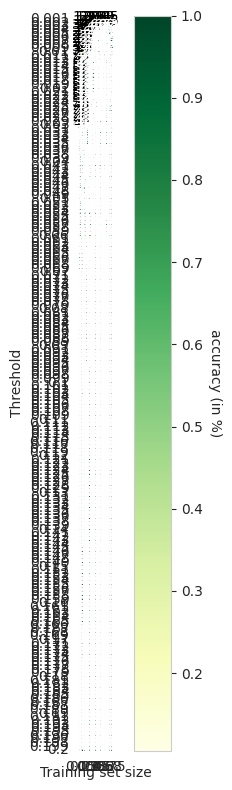

<Axes: xlabel='train_size', ylabel='F1-Score'>

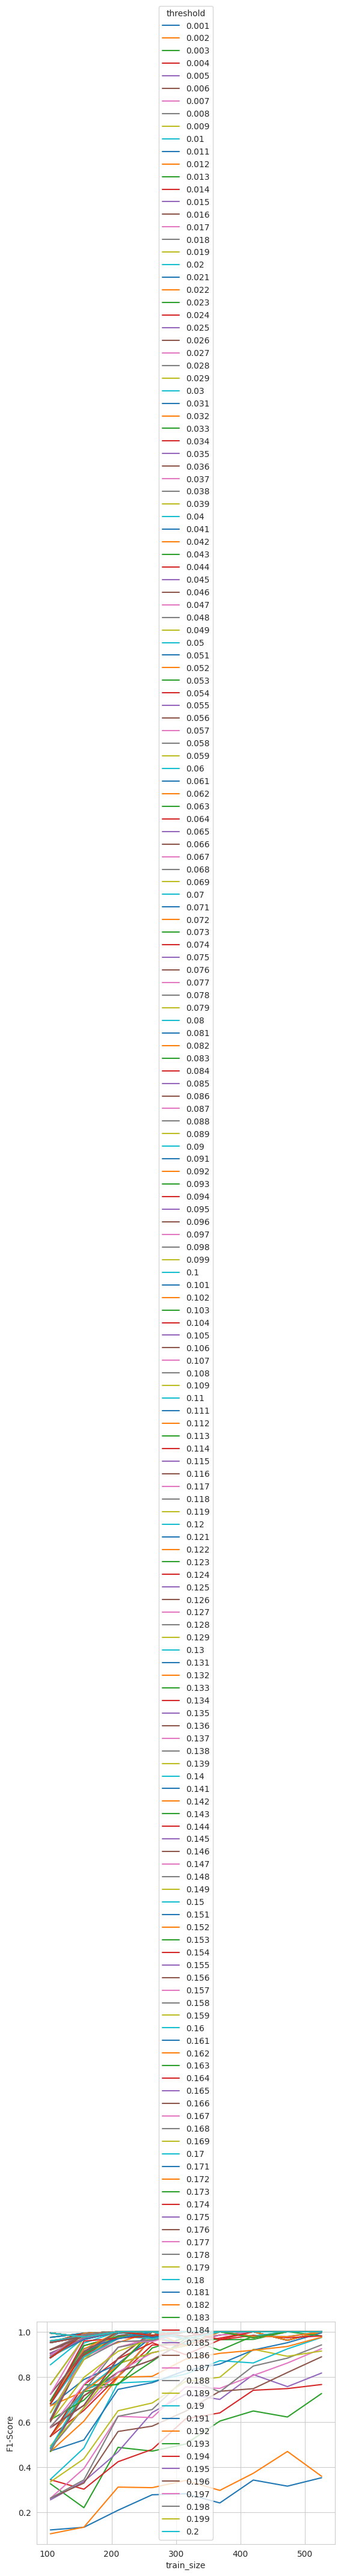

In [73]:
import matplotlib.pyplot as plt
heatmap = classifier_valid_thresholds[["train_size", "threshold", "f1_score"]].groupby(["train_size", "threshold"]).mean().reset_index().pivot(columns="train_size", index="threshold")
fig, ax = plt.subplots(figsize=(5,8))
im = ax.imshow(heatmap, cmap="YlGn")


cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("accuracy (in %)", rotation=-90, va="bottom")
ax.set_xlabel("Training set size", va="bottom")
ax.set_ylabel("Threshold", va="bottom")
ax.set_yticks(range(len(heatmap.index)), heatmap.index)
ax.set_xticks(range(len(heatmap.columns)), (heatmap.columns.get_level_values(1)/700).round(2))

# Loop over data dimensions and create text annotations.

threshold = im.norm(heatmap.values.max())/2.

textcolors=("black", "white")

for i in range(len(heatmap.index)):
    for j in range(len(heatmap.columns)):
        text = ax.text(j, i, (heatmap.values[i, j].round(2)*100).astype(int),
                       ha="center", va="center", color=textcolors[int(im.norm(heatmap.values[i, j]) > threshold)])
ax.spines[:].set_visible(False)

# ax.set_xticks(np.arange(heatmap.values.shape[1]+1)-.5, minor=True)
# ax.set_yticks(np.arange(heatmap.values.shape[0]+1)-.5, minor=True)
# ax.grid(which="minor", color="w", linestyle='', linewidth=0)
# ax.tick_params(which="minor", bottom=False, left=False)

fig.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = classifier_valid_thresholds[["train_size", "threshold", "f1_score"]].groupby(["train_size", "threshold"]).mean().reset_index().pivot(index="train_size", columns="threshold")
data.columns = data.columns.droplevel(0)
data.reset_index().plot("train_size", ylabel="F1-Score")


# Plot prediction results (valid dataset)

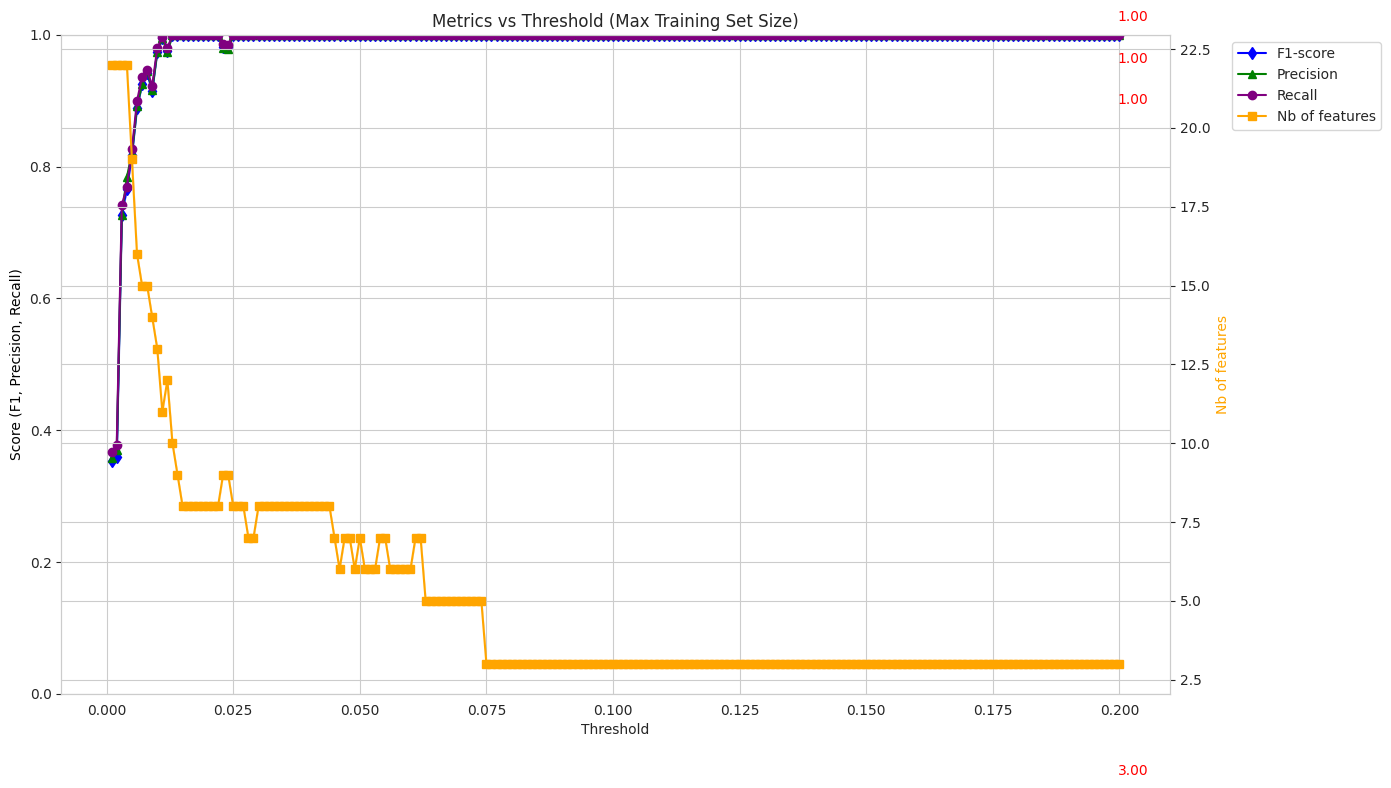

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Filter the DataFrame to include only rows with the maximum train_size
max_train_size = classifier_valid_thresholds['train_size'].max()
filtered_results = classifier_valid_thresholds[classifier_valid_thresholds['train_size'] == max_train_size]

# Group by threshold and calculate mean and std for all metrics
grouped_f1 = filtered_results.groupby('threshold')['f1_score'].agg(['mean', 'std']).reset_index()
grouped_precision = filtered_results.groupby('threshold')['precision'].agg(['mean', 'std']).reset_index()
grouped_recall = filtered_results.groupby('threshold')['recall'].agg(['mean', 'std']).reset_index()
grouped_features = filtered_results.groupby('threshold')['nb_features'].agg(['mean', 'std']).reset_index()

# Use the unique threshold values from the grouped data for the x-axis
thresholds = grouped_f1['threshold'].unique()

# Plotting
plt.figure(figsize=(14, 8))

# Primary axis for F1-score, Precision, and Recall
ax1 = plt.gca()
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score (F1, Precision, Recall)', color='black')
ax1.set_ylim(0, 1)

# Plot F1-score
ax1.plot(
    thresholds,
    grouped_f1['mean'],
    marker='d',
    label='F1-score',
    color='blue'
)
ax1.fill_between(
    thresholds,
    grouped_f1['mean'] - grouped_f1['std'],
    grouped_f1['mean'] + grouped_f1['std'],
    alpha=0.2,
    color='blue'
)

# Plot Precision
ax1.plot(
    thresholds,
    grouped_precision['mean'],
    marker='^',
    label='Precision',
    color='green'
)
ax1.fill_between(
    thresholds,
    grouped_precision['mean'] - grouped_precision['std'],
    grouped_precision['mean'] + grouped_precision['std'],
    alpha=0.2,
    color='green'
)

# Plot Recall
ax1.plot(
    thresholds,
    grouped_recall['mean'],
    marker='o',
    label='Recall',
    color='purple'
)
ax1.fill_between(
    thresholds,
    grouped_recall['mean'] - grouped_recall['std'],
    grouped_recall['mean'] + grouped_recall['std'],
    alpha=0.2,
    color='purple'
)

# Annotate the last values
ax1.annotate(
    f'{grouped_f1["mean"].iloc[-1]:.2f}',
    (thresholds[-1], grouped_f1["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

ax1.annotate(
    f'{grouped_precision["mean"].iloc[-1]:.2f}',
    (thresholds[-1], grouped_precision["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -20),
    ha='center',
    fontsize=10,
    color='red'
)

ax1.annotate(
    f'{grouped_recall["mean"].iloc[-1]:.2f}',
    (thresholds[-1], grouped_recall["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -50),
    ha='center',
    fontsize=10,
    color='red'
)

# Secondary axis for Silhouette Score
ax2 = ax1.twinx()
ax2.set_ylabel('Nb of features', color='orange')

ax2.plot(
    thresholds,
    grouped_features['mean'],
    marker='s',
    label='Nb of features',
    color='orange'
)
ax2.fill_between(
    thresholds,
    grouped_features['mean'] - grouped_features['std'],
    grouped_features['mean'] + grouped_features['std'],
    alpha=0.2,
    color='orange'
)

# Annotate the last value of Silhouette Score
ax2.annotate(
    f'{grouped_features["mean"].iloc[-1]:.2f}',
    (thresholds[-1], grouped_features["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -80),
    ha='center',
    fontsize=10,
    color='red'
)

# Place the legend outside the figure
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Metrics vs Threshold (Max Training Set Size)')
plt.grid(True)
plt.tight_layout()
plt.show()
